In [1]:
import cv2 as cv 
import numpy as np
from pycocotools.coco import COCO
import os
import json
import seaborn as sns
import random
import matplotlib.pyplot as plt
import torch 
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import albumentations as album 
from sklearn.model_selection import train_test_split
from typing import Callable
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F


/opt/anaconda3/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
DATASET_PATH = "data"
coco = COCO(f"{DATASET_PATH}/annotations.json")
train_ids, test_ids = train_test_split(coco.getImgIds()[6000:], test_size=0.3, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)
print(len(train_ids), len(val_ids), len(test_ids))

loading annotations into memory...
Done (t=1.61s)
creating index...
index created!
1528 382 819


In [3]:

def to_tensor(x, *kwargs):
    return x.transpose(2,0,1).astype(np.float32)

def add_postprocessing(preprocessing_fn=None):
    """
    Decorator to add preprocessing functions to the image and target <br/>
    <strong>This execution order is:</strong>
    1. album.Lambda(image=preprocessing_fn) if preprocessing_fn is not None
    2. func(*args,**kwargs) -> returns a list of your designed pre-processing transforms
    3. album.Lambda(image=image_to_tensor, mask=target_to_tensor)
    """
    def decorator(func):
        def wrapper(*args,**kwargs):
            _transform = []
            if preprocessing_fn:
                _transform.append(album.Lambda(image=preprocessing_fn))
            _transform.extend(func(*args,**kwargs))
            _transform.append(ToTensorV2())
            return album.Compose(_transform)
        return wrapper
    return decorator

@add_postprocessing(None)
def get_preprocessing(*args,**kwargs): 
    _transform = [
    #    album.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0)
    ]
    # TODO: Add more pre-processing functions here
    return _transform

def get_training_augmentation():
    transform = [
        # album.HorizontalFlip(p=0.5),
        # album.VerticalFlip(p=0.5),
        # album.RandomRotate90(p=0.5),
    ]
    return album.Compose(transform)


def get_validation_augmentation():
    transform = [
        
    ]
    return album.Compose(transform)

In [4]:
class TurtlesDataset(Dataset):
    def __init__(self, coco: COCO, image_ids: list, 
                 augmentation: Callable[[np.ndarray, dict], dict] | None = None, 
                 preprocessing: Callable[[np.ndarray, dict], dict] | None = None):
        self.coco = coco
        self.image_ids = image_ids
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.catIds = coco.getCatIds()
        # 定义类别的优先级字典，数值越高表示优先级越高
        self.label_priority = {
            'head': 3,  # 假设头部优先级最高
            'flipper': 2,  # 翅膀次高
            'turtle': 1  # 甲壳优先级最低
        }

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = self.coco.loadImgs([image_id])[0]
        image = cv.imread(f"{DATASET_PATH}/{image['file_name']}")
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # 初始化空的掩码，所有类别的掩码都在同一个掩码上进行合并
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
        priority_map = np.zeros_like(mask)  # 记录每个像素的当前优先级
        
        # 获取所有标注
        ann_ids = coco.getAnnIds(imgIds=image_id, catIds=self.catIds, iscrowd=None)
        anns = coco.loadAnns(ann_ids)
        
        # 逐个标注处理
        for ann in anns:
            category_id = ann['category_id']
            category_name = coco.loadCats([category_id])[0]['name']  # 获取类别名称
            ann_mask = coco.annToMask(ann)  # 获取该类别的二值掩码
            
            current_priority = self.label_priority.get(category_name, 0)  # 获取该类别的优先级
            
            # 遍历所有像素，如果当前像素没有被标注，直接写入类别ID
            mask = np.where((ann_mask == 1) & (priority_map == 0), category_id, mask)
            
            # 如果当前像素已经被标注，但新的类别优先级更高，则用新的类别ID替换
            mask = np.where((ann_mask == 1) & (current_priority > priority_map), category_id, mask)
            
            # 更新优先级映射
            priority_map = np.where(ann_mask == 1, np.maximum(priority_map, current_priority), priority_map)
        
        # 将图像和掩码大小调整为统一尺寸
        image = cv.resize(image, (512, 512))
        mask = cv.resize(mask, (512, 512), interpolation=cv.INTER_NEAREST)
        
        image = image.astype(np.float32)
        mask = mask.astype(np.float32)
        
        # 数据增强
        if self.augmentation:
            transformed = self.augmentation(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        
        # 数据预处理
        if self.preprocessing:
            transformed = self.preprocessing(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        
        return image, mask



In [5]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

def test_worst(model, test_loader, device, display_num=30):
    model.eval()  # 设置模型为评估模式
    all_ious = []  # 存储每个样本的 IoU 值
    images = []  # 存储图片数据
    masks = []  # 存储真实掩码数据
    pred_masks = []  # 存储预测掩码数据

    with torch.no_grad():
        for i, (image, mask) in enumerate(test_loader):
            image = image.to(device)
            mask = mask.to(device)

            # 预测
            pred_mask = model(image)
            pred_mask = torch.argmax(pred_mask, dim=1)  # 获取预测的类别（0, 1, 2, 3）

            # 将预测和真实掩码保持在 GPU 上，进行 IoU 计算
            pred_mask_np = pred_mask.to("cpu").numpy().squeeze()  # 临时转到 CPU 计算
            true_mask_np = mask.to("cpu").numpy().squeeze()       # 临时转到 CPU 计算

            # 计算 IoU
            iou_per_class = calculate_iou(pred_mask_np, true_mask_np, num_classes=4)
            all_ious.append(iou_per_class)  # 将每个样本的每个类别的 IoU 值添加到列表中
            images.append(image.to("cpu"))
            masks.append(mask.to("cpu"))
            pred_masks.append(pred_mask.to("cpu"))

    # 转换为 NumPy 数组
    all_ious = np.array(all_ious)

    # 计算每个类别的平均 IoU，忽略 NaN 值
    mean_iou_per_class = np.nanmean(all_ious, axis=0)
    mean_iou_overall = np.nanmean(mean_iou_per_class)
    print("Mean IoU (Overall):", mean_iou_overall)

    # 找到 IoU 最低的30个样本的索引（以平均 IoU 为准）
    sample_mean_ious = np.nanmean(all_ious, axis=1)  # 每个样本的平均 IoU
    worst_indices = np.argsort(sample_mean_ious)[:-display_num]  # 获取最差的30个样本索引
    worst_ious = all_ious[worst_indices]  # 获取最差的30个样本的每个类别 IoU 值

    print("Worst 30 IoU values (per class for each sample):")
    for idx, iou_per_class in zip(worst_indices, worst_ious):
        print(f"Sample {idx}: IoU per class = {iou_per_class}")

    # 显示最差的30个样本的图片和掩码
    for idx in worst_indices:
        image_np = images[idx][0].permute(1, 2, 0).numpy().astype(np.int32)  # 转换为 NumPy 格式
        true_mask_np = masks[idx].numpy().squeeze()
        pred_mask_np = pred_masks[idx].numpy().squeeze()

        # 绘图以显示原始图像、真实掩码和预测掩码
        fig, axes = plt.subplots(1, 3, figsize=(5, 5))
        axes[0].imshow(image_np)
        axes[0].set_title('Image')

        # 显示原始的掩码值（无颜色映射）
        axes[1].imshow(true_mask_np, interpolation='none')  # 真实掩码
        axes[1].set_title('True Ground')

        axes[2].imshow(pred_mask_np, interpolation='none')  # 预测掩码
        axes[2].set_title('Pred Mask')

        plt.show()

    return mean_iou_overall, worst_ious


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

def test_model(model, test_loader, device, display_num=50):
    model.eval()  # 设置模型为评估模式
    all_ious = []  # 存储每个样本的 IoU 值

    with torch.no_grad():
        for i, (image, mask) in enumerate(test_loader):
            image = image.to(device)
            mask = mask.to(device)

            # 预测
            pred_mask = model(image)
            pred_mask = torch.argmax(pred_mask, dim=1)  # 获取预测的类别（0, 1, 2, 3）

            # 将预测和真实掩码保持在 GPU 上，进行 IoU 计算
            pred_mask_np = pred_mask.to("cpu").numpy().squeeze()  # 临时转到 CPU 计算
            true_mask_np = mask.to("cpu").numpy().squeeze()       # 临时转到 CPU 计算

            # 计算 IoU
            iou_per_class = calculate_iou(pred_mask_np, true_mask_np, num_classes=4)
            all_ious.append(iou_per_class)  # 将每个样本的 IoU 值添加到列表中

    # 计算每个类别的平均 IoU，忽略 NaN 值
    all_ious = np.array(all_ious)
    mean_iou_per_class = np.nanmean(all_ious, axis=0)
    mean_iou_overall = np.nanmean(mean_iou_per_class)

    print("Class-wise mIoU:", mean_iou_per_class)
    print("Mean IoU (Overall):", mean_iou_overall)

    # 显示随机的 'display_num' 个预测结果
    random_numbers = random.sample(range(len(test_dataset)), display_num)
    for i in random_numbers:
        image, mask = test_dataset[i]
        image = image.unsqueeze(0).to(device)  # 增加 batch 维度，并移到 GPU
        mask = mask.unsqueeze(0).to(device)    # 增加 batch 维度，并移到 GPU

        with torch.no_grad():
            pred_mask = model(image)
            pred_mask = torch.argmax(pred_mask, dim=1)

            # 转换为 NumPy 格式进行显示
            pred_mask_np = pred_mask.to("cpu").numpy().squeeze()
            mask_np = mask.to("cpu").numpy().squeeze()
            image_np = image[0].permute(1, 2, 0).to("cpu").numpy().astype(np.int32)

            # 直接绘图以显示原始图像、真实掩码和预测掩码
            fig, axes = plt.subplots(1, 3, figsize=(5, 5))
            axes[0].imshow(image_np)
            axes[0].set_title('Image')
            
            # 显示原始的掩码值（无颜色映射）
            axes[1].imshow(mask_np, interpolation='none')  # 真实掩码
            axes[1].set_title('True Ground')

            axes[2].imshow(pred_mask_np, interpolation='none')  # 预测掩码
            axes[2].set_title('Pred Mask')

            plt.show()

    return mean_iou_overall


In [8]:
def visualize(figsize=(16,5), **images):
    n = len(images)
    plt.figure(figsize=figsize)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


In [9]:
def calculate_iou(pred, target, num_classes):
    """
    计算每个类别的 IOU。
    
    参数:
    - pred: 模型预测的张量，形状为 [H, W]
    - target: 实际标签的张量，形状为 [H, W]
    - num_classes: 类别数
    
    返回:
    - iou_per_class: 每个类别的 IOU
    """
    iou_per_class = []
    for cls in range(1,num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        
        # 计算交集和并集
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            iou_per_class.append(float('nan'))  # 没有该类别
        else:
            iou_per_class.append(intersection / union)
    
    return iou_per_class


Loaded NestedUNet model from a previous commit.
Class-wise mIoU: [0.73654662 0.67393571 0.65223942]
Mean IoU (Overall): 0.6875739180606253


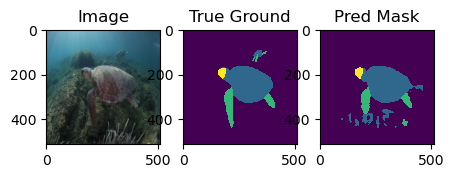

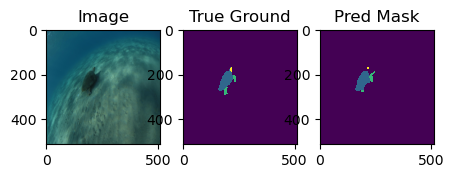

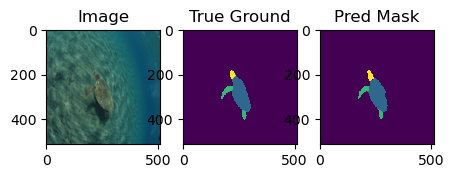

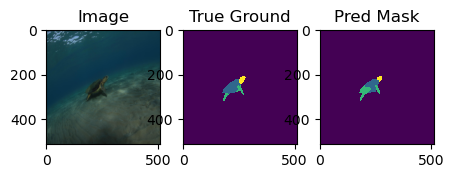

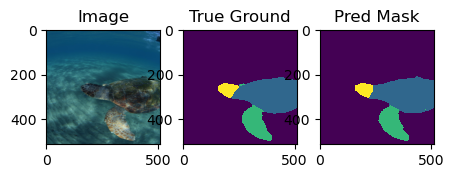

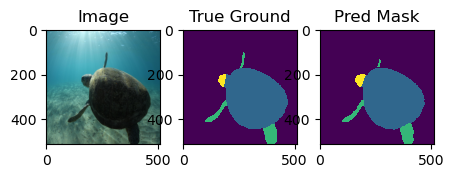

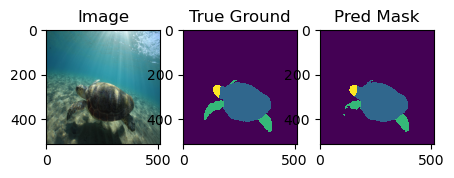

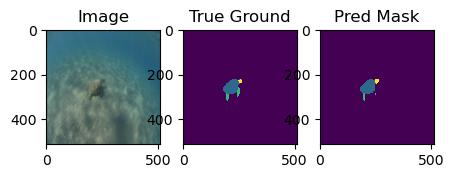

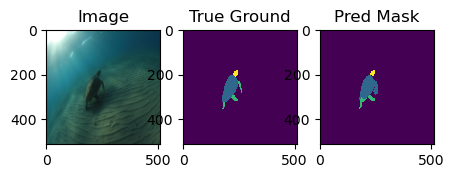

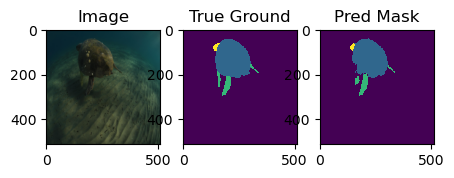

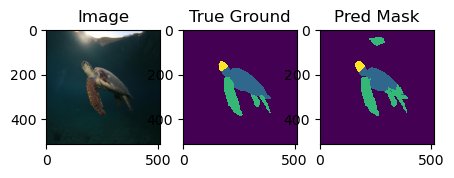

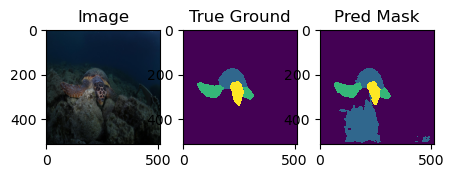

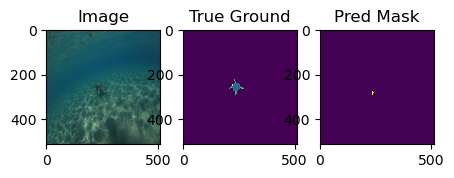

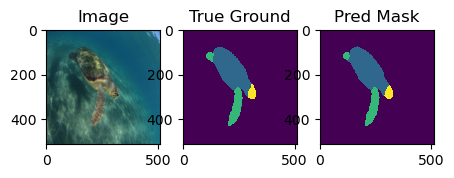

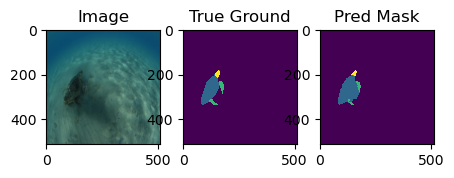

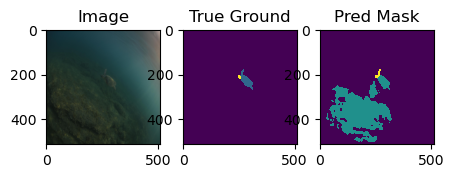

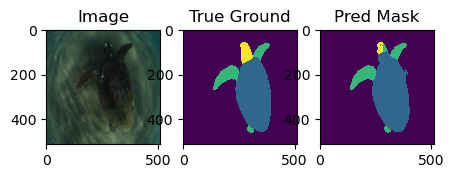

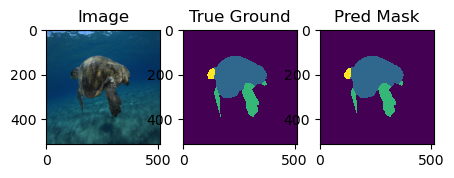

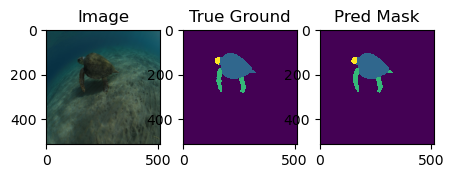

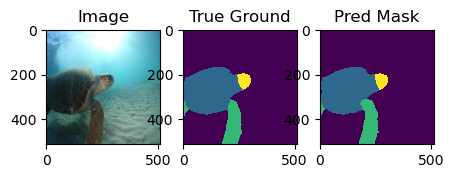

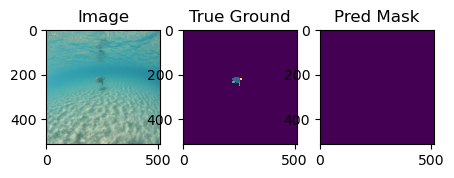

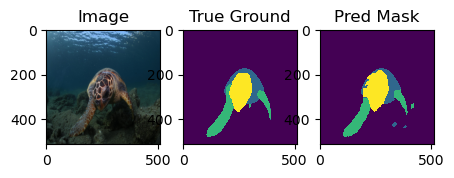

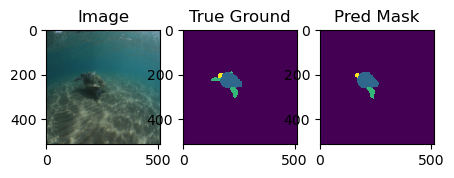

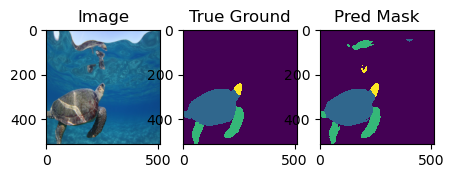

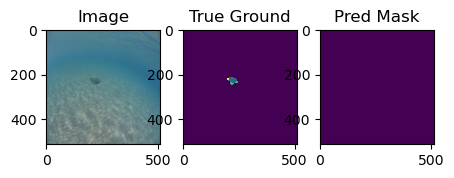

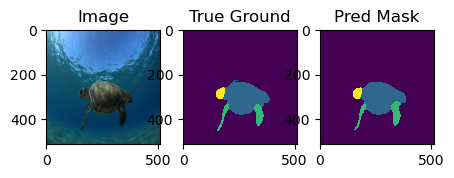

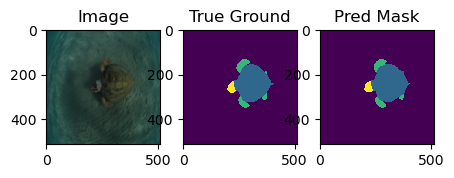

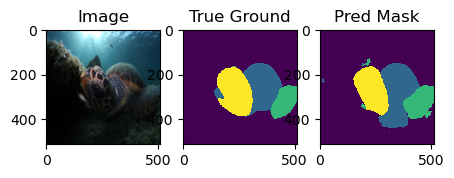

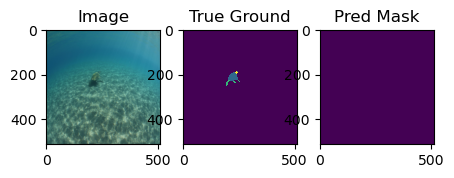

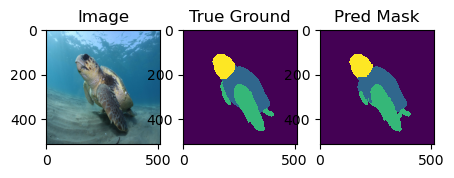

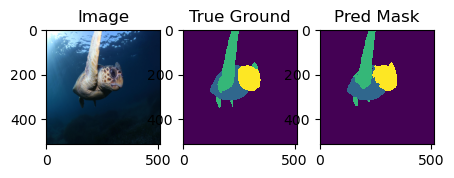

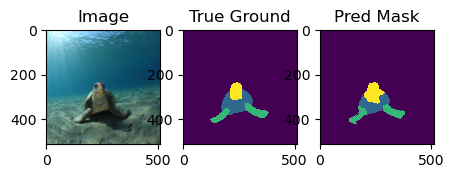

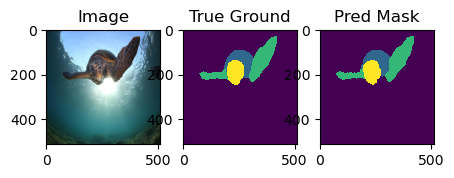

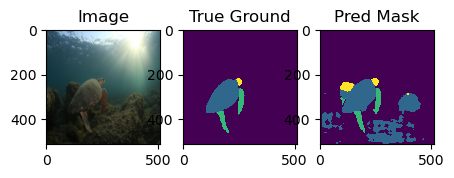

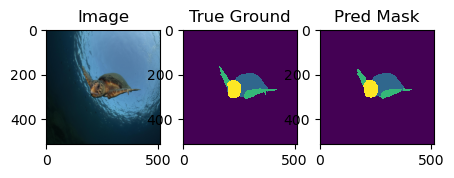

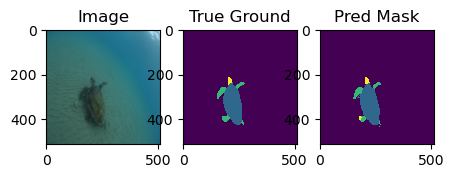

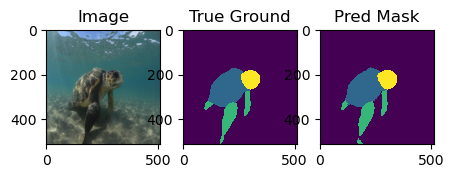

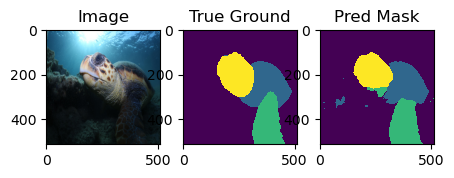

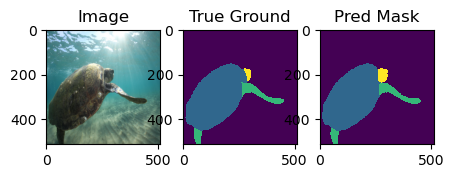

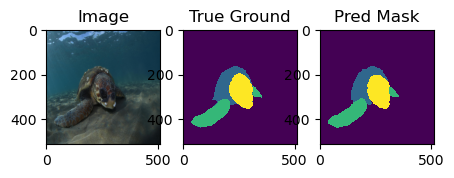

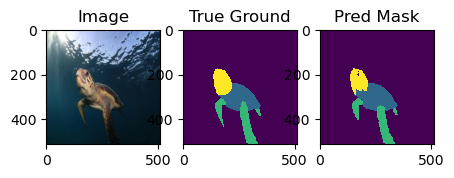

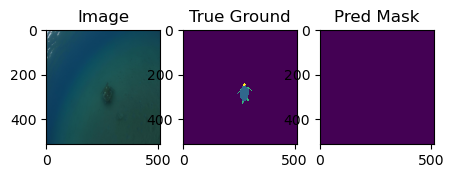

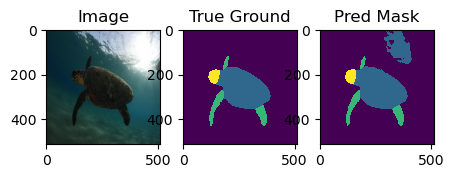

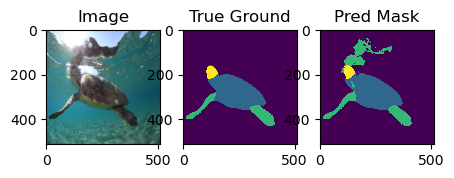

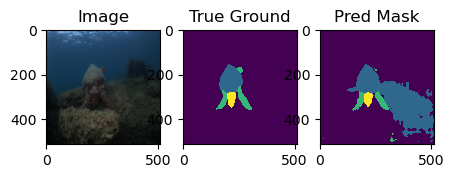

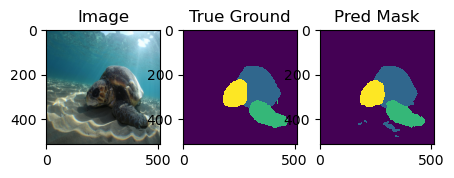

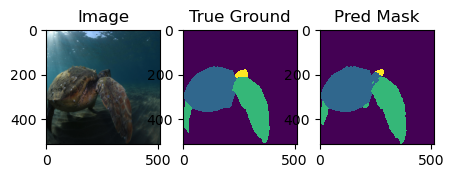

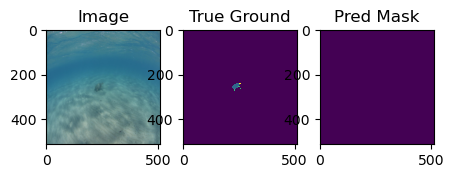

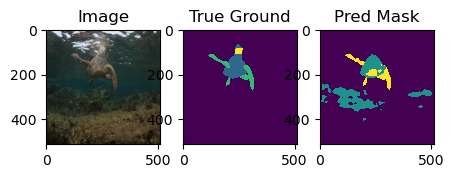

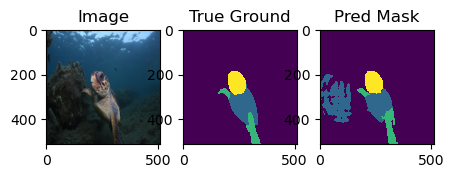

0.6875739180606253


In [10]:
import os
Unet_BEST_PATH = "models/NestedUnet_epoch_20.pth"
unet = NestedUNet(num_classes=4, input_channels=3)
device='mps'
def load_model(model, path):
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=device))
        model.to(device)
        print(f"Loaded {model.__class__.__name__} model from a previous commit.")
        return model
    print("Model path does not exist.")
    return None


unet = load_model(unet, Unet_BEST_PATH)
test_dataset = TurtlesDataset(coco, test_ids,get_preprocessing())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
print(test_loader)
lt=test_model(unet, test_loader, device)
print(lt)